# Proximal Policy Optimization (PPO)

In [1]:
import os
import torch
import torch.nn as nn
import math
import numpy as np

from rl_helpers.scalers import *
from torch.distributions import Bernoulli
from delivery_drone.game.socket_client import DroneGameClient, DroneState

pygame 2.6.1 (SDL 2.28.4, Python 3.12.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
client = DroneGameClient(port=5555)
client.connect()

Connecting to localhost:5555...
Connected to server at localhost:5555
Server has 1 game instance(s)


In [5]:
from rl_helpers.scalers import *

### State Variables

| Variable | Min | Max | Typical Range | Critical Threshold |
|----------|-----|-----|---------------|-------------------|
| drone_x | 0 | 1 | [0, 1] | - |
| drone_y | 0 | 1 | [0, 1] | - |
| drone_vx | -2.5 | 2.5 | [-1.5, 1.5] | - |
| drone_vy | -2.5 | 3.0 | [-0.5, 2.5] | - |
| drone_angle | -1 | 1 | [-0.5, 0.5] | < 0.111 for landing |
| drone_angular_vel | -1.5 | 1.5 | [-0.8, 0.8] | - |
| drone_fuel | 0 | 1 | [0, 1] | Episode ends at 0 |
| platform_x | 0 | 1 | [0.1, 0.9] | - |
| platform_y | 0 | 1 | [0.58, 0.92] | Platform spawns at [350, 550]px |
| distance_to_platform | 0 | 1.41 | [0, 1.2] | - |
| dx_to_platform | -1.125 | 1.125 | [-1, 1] | < ±0.0625 for landing |
| dy_to_platform | -1.083 | 1.083 | [-0.5, 0.8] | - |
| speed | 0 | 3.9 | [0, 3.0] | < 0.3 for landing |

In [6]:
def calc_velocity_alignment(state: DroneState):
    """
    Calculate how well the drone's velocity is aligned with optimal direction to platform.
    Returns cosine similarity: 1.0 = perfect alignment, -1.0 = opposite direction
    """
    # Optimal direction: from drone to platform
    optimal_dx = state.dx_to_platform
    optimal_dy = state.dy_to_platform
    optimal_norm = math.sqrt(optimal_dx**2 + optimal_dy**2)

    if optimal_norm < 1e-6:  # Already at platform
        return 1.0

    optimal_dx /= optimal_norm
    optimal_dy /= optimal_norm

    # Current velocity direction
    velocity_norm = state.speed
    if velocity_norm < 1e-6:  # Not moving
        return 0.0

    velocity_dx = state.drone_vx / velocity_norm
    velocity_dy = state.drone_vy / velocity_norm

    # Cosine similarity
    return velocity_dx * optimal_dx + velocity_dy * optimal_dy

In [7]:
# Velocity-magnitude-weighted distance reward
def calc_reward(state: DroneState, prev_state: DroneState = None):
    rewards = {}
    total_reward = 0

    # Time penalty
    minimum_time_penalty = 0
    maximum_time_penalty = 1
    rewards['time_penalty'] = -inverse_quadratic(
        state.distance_to_platform,
        decay=100,
        scaler=maximum_time_penalty-minimum_time_penalty) - minimum_time_penalty

    # Distance-based time penalty
    # Penalty gets smaller as drone gets closer to platform
    # Uses inverse quadratic function: higher penalty when far, reduces as distance decreases
    # Minimum penalty of 0.5, maximum of 2.0 per timestep
    total_reward += -0.5#rewards['time_penalty']

    velocity_alignment = calc_velocity_alignment(state)
    dist = state.distance_to_platform
    
    rewards['distance'] = 0
    rewards['hovering'] = 0

    if prev_state is not None:
        distance_delta = prev_state.distance_to_platform - state.distance_to_platform
        speed = state.speed
        
        # Calculate velocity toward platform
        if dist > 1e-6:
            velocity_toward_platform = (
                state.drone_vx * state.dx_to_platform +
                state.drone_vy * state.dy_to_platform
            ) / dist
        else:
            velocity_toward_platform = 0.0
        
        MIN_MEANINGFUL_SPEED = 0.15  # Require meaningful velocity
        
        # Only reward if FAST and ALIGNED and making PROGRESS
        if speed >= MIN_MEANINGFUL_SPEED and velocity_toward_platform > 0.1 and dist > 0.065:
            # Good: Moving fast toward platform
            speed_multiplier = 1.0 + speed * 2.0
            rewards['distance'] = float(np.clip(distance_delta * 1000 * speed_multiplier, -2, 5))
        elif distance_delta < -0.001:
            # BAD: Moving away from platform (distance increasing)
            rewards['distance'] = -2.0 * abs(distance_delta) * 1000  # Harsh penalty
            rewards['hovering'] = 0  # Don't double-penalize
        elif speed < 0.05:
            # Hovering
            rewards['hovering'] = -1.0
        elif speed < MIN_MEANINGFUL_SPEED:
            # Too slow
            rewards['hovering'] = -0.3
        else:
            rewards['distance'] = 0.0
            
    total_reward += rewards['distance']
    total_reward += rewards['hovering']

    # Angle penalty (define a distance based max threshold)
    abs_angle = abs(state.drone_angle)
    max_angle = 0.20
    max_permissible_angle = ((max_angle-0.111)*dist) + 0.111
    excess = abs_angle - max_permissible_angle # excess angle
    rewards['angle'] = -max(excess, 0) # maximum reward is 0 (we dont want it to reward hack for stability)

    total_reward += rewards['angle']

    # Speed - penalize excessive speed
    rewards['speed'] = 0
    speed = state.speed
    max_speed = 0.6
    if dist < 1:
        rewards['speed'] = -2 * max(speed-0.1, 0)
    else:
        rewards['speed'] = -1 * max(speed-max_speed, 0)
    total_reward += rewards['speed']

    # Penalize being below platform
    rewards['vertical_position'] = 0
    if state.dy_to_platform > 0:  # Platform is below drone (drone is above - GOOD)
        rewards['vertical_position'] = 0
    else:  # Drone is below platform (BAD!)
        rewards['vertical_position'] = state.dy_to_platform * 4.0  # Negative penalty
    total_reward += rewards['vertical_position']

    # Terminal
    rewards['terminal'] = 0
    if state.landed:
        rewards['terminal'] = 800.0 + state.drone_fuel * 100.0
    elif state.crashed:
        rewards['terminal'] = -200.0
        # Extra penalty for crashing far from target
        if state.distance_to_platform > 0.3:
            rewards['terminal'] -= 100.0
    total_reward += rewards['terminal']

    rewards['total'] = total_reward
    return rewards

In [8]:
client.reset()
state=None

In [9]:
prev_state = state if state else None
client.step(
    dict(
        main_thrust=0,
        left_thrust=0,
        right_thrust=0
    )
)
state = client.get_state()
display(state.__dict__)
calc_reward(state, prev_state)

{'drone_x': 0.59375,
 'drone_y': 0.340495,
 'drone_vx': 0.0,
 'drone_vy': 0.029699999999999997,
 'drone_angle': 0.0,
 'drone_angular_vel': 0.0,
 'drone_fuel': 1.0,
 'platform_x': 0.50625,
 'platform_y': 0.6366666666666667,
 'distance_to_platform': 0.23874134869469618,
 'dx_to_platform': -0.0875,
 'dy_to_platform': 0.29617166666666667,
 'speed': 0.029699999999999997,
 'landed': False,
 'crashed': False,
 'steps': 1}

{'time_penalty': -0.1492594531563844,
 'distance': 0,
 'hovering': 0,
 'angle': 0,
 'speed': 0,
 'vertical_position': 0,
 'terminal': 0,
 'total': -0.5}

In [10]:
def state_to_array(state, device='cpu'):
    """Convert DroneState dataclass to numpy array"""
    data = np.array([
        state.drone_x,
        state.drone_y,
        state.drone_vx,
        state.drone_vy,
        state.drone_angle,
        state.drone_angular_vel,
        state.drone_fuel,
        state.platform_x,
        state.platform_y,
        state.distance_to_platform,
        state.dx_to_platform,
        state.dy_to_platform,
        state.speed,
        float(state.landed),
        float(state.crashed)
    ])
    
    return torch.tensor(data, dtype=torch.float32, device=device)

In [11]:
class DroneGamerBoi(nn.Module):
    def __init__(self, state_dim=15):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.LayerNorm(128),  # Add normalization
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 3),
            nn.Sigmoid()
        )
        
    def forward(self, state):
        if isinstance(state, DroneState):
            state = state_to_array(state, device=device)
        
        return self.network(state)

In [12]:
class DroneTeacherBoi(nn.Module):
    def __init__(self, state_dim=15):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.LayerNorm(128),  # Add normalization
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 1) # output will be just a scalar
        )
        
    def forward(self, state):
        if isinstance(state, DroneState):
            state = state_to_array(state, device=device)
        
        return (self.network(state)
                .squeeze(-1)) # this will convert the tensor from [B, 1] to [B,]

## Proximal Policy Optimization (PPO): How It Works

PPO is an advanced Actor-Critic method that solves a critical problem: **how to update the policy safely without accidentally destroying what it has already learned**.

### The Core Problem PPO Solves

**In Basic Actor-Critic:**
- One bad gradient update can collapse the policy (make it deterministic or terrible)
- If we take too large a step, the policy might never recover
- No mechanism to prevent catastrophic updates

**PPO's solution:** **Clip the policy updates** to stay within a "trust region" - only allow small, controlled changes.

---

## Key Innovation: The Clipped Objective

### 1. Policy Ratio

PPO tracks how much the policy has changed by computing a ratio:

$$r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)}$$

**What this ratio means:**
- $r_t = 1.0$: Policy unchanged for this state-action pair
- $r_t > 1.0$: New policy makes action $a_t$ MORE likely
- $r_t < 1.0$: New policy makes action $a_t$ LESS likely

### 2. Clipped Surrogate Objective

Instead of the standard policy gradient loss, PPO uses:

$$L^{\text{CLIP}}(\theta) = \mathbb{E}_t\left[\min\left(r_t(\theta) \cdot A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \cdot A_t\right)\right]$$

Where:
- $A_t$ = Advantage (GAE: how good this action was vs average)
- $\epsilon$ = Clipping parameter (typically **0.2**)
- $\text{clip}(r_t, 1-\epsilon, 1+\epsilon)$ = Constrain ratio to $[0.8, 1.2]$

### 3. What the Clipping Does

The `min()` creates a **pessimistic bound** - we take the worst-case of the two objectives:

**Case 1: Positive Advantage ($A_t > 0$)** - Good action, want to increase probability

| Ratio $r_t$ | Effect | Clipping Active? |
|-------------|--------|------------------|
| $r_t < 0.8$ | Increase probability | No (safe) |
| $0.8 \leq r_t \leq 1.2$ | Increase probability | No (safe) |
| $r_t > 1.2$ | **STOP increasing** | **Yes** (already changed +20%) |

**Case 2: Negative Advantage ($A_t < 0$)** - Bad action, want to decrease probability

| Ratio $r_t$ | Effect | Clipping Active? |
|-------------|--------|------------------|
| $r_t < 0.8$ | **STOP decreasing** | **Yes** (already changed -20%) |
| $0.8 \leq r_t \leq 1.2$ | Decrease probability | No (safe) |
| $r_t > 1.2$ | Decrease probability | No (safe) |

**The genius:** Clipping prevents the policy from changing too drastically. If an action probability has already changed by ±20%, we stop pushing it further.

---

## PPO Algorithm Flow

### Phase 1: Rollout Collection (Like REINFORCE)

```
1. Run current policy π_θ_old for N steps across parallel games
2. Store: states, actions, log_probs, rewards, dones, values
3. Compute GAE advantages for variance reduction
```

### Phase 2: Multi-Epoch Updates (Key Difference!)

Unlike Actor-Critic (1 update per transition), PPO reuses data:

```
For epoch in 1..K (typically K=4-10):
    Shuffle collected data into minibatches
    
    For each minibatch:
        # Compute new policy probabilities
        new_log_probs = log π_θ(actions | states)
        
        # Policy ratio
        ratio = exp(new_log_probs - old_log_probs)
        
        # Clipped objective
        surr1 = ratio * advantages
        surr2 = clip(ratio, 1-ε, 1+ε) * advantages
        policy_loss = -min(surr1, surr2).mean()
        
        # Entropy bonus for exploration
        entropy = -sum(probs * log(probs))
        policy_loss -= entropy_coef * entropy
        
        # Update policy
        policy_optimizer.step()
        
        # Value loss (simple MSE)
        value_loss = (values - returns)²
        critic_optimizer.step()
```

### Phase 3: Replace Old Policy

```
θ_old ← θ  # Save current policy for next rollout
```

---

## Generalized Advantage Estimation (GAE)

PPO typically uses GAE instead of simple TD error for lower variance:

### Simple TD Error (Actor-Critic):
$$A_t = \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$$

### GAE (PPO):
$$A_t^{\text{GAE}} = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}$$

Where $\lambda \in [0, 1]$ controls bias-variance tradeoff:
- $\lambda = 0$: Pure TD (low variance, high bias)
- $\lambda = 1$: Monte Carlo (high variance, low bias)  
- $\lambda = 0.95$: **PPO sweet spot** ✓

**Practical computation (backward pass):**
```python
advantages = []
gae = 0
for t in reversed(range(T)):
    delta = rewards[t] + gamma * values[t+1] - values[t]
    gae = delta + gamma * lambda_ * gae
    advantages.insert(0, gae)
```

---

## PPO vs Actor-Critic vs REINFORCE

| Feature | REINFORCE | Actor-Critic | **PPO** |
|---------|-----------|--------------|---------|
| **Update frequency** | End of episode | Every step | Every N steps |
| **Data reuse** | No | No | **Yes (K epochs)** ✓ |
| **Variance** | Very high | Medium | **Low (GAE)** ✓ |
| **Stability** | Unstable | Can be unstable | **Very stable (clipping)** ✓ |
| **Sample efficiency** | Poor | Good | **Best** ✓ |
| **Prevents collapse** | No | No | **Yes (trust region)** ✓ |

---

## Why PPO Wins

### 1. **Prevents Policy Collapse**

**Without clipping:**
```python
# One huge gradient can ruin the policy
loss = -log_prob * advantage  # No bounds!
# If advantage is +100, gradient is HUGE → policy becomes deterministic
```

**With clipping:**
```python
ratio = new_prob / old_prob
clipped_ratio = clip(ratio, 0.8, 1.2)
loss = -min(ratio * advantage, clipped_ratio * advantage)
# Even if advantage is +100, change is limited to ±20%
```

### 2. **Data Efficiency**

- **Actor-Critic**: Use each transition once → throw away
- **PPO**: Reuse data 4-10 times → fewer environment interactions

### 3. **Stable Across Tasks**

- Works out-of-the-box on many tasks
- Requires minimal hyperparameter tuning
- Industry standard (OpenAI Five, AlphaStar, robotics)

---

## Mathematical Intuition: Why min()?

```python
L = -min(ratio * A, clip(ratio, 1-ε, 1+ε) * A)
     ↑
   Pessimistic: take minimum (worst-case) of two terms
```

**If $A_t > 0$ (good action):**
- Unclipped: $r_t \cdot A$ encourages increasing probability
- Clipped: Caps increase once $r_t > 1.2$
- **min() chooses:** Once ratio exceeds 1.2, gradient becomes zero (stops increasing)

**If $A_t < 0$ (bad action):**
- Unclipped: $r_t \cdot A$ (negative) encourages decreasing probability
- Clipped: Caps decrease once $r_t < 0.8$  
- **min() chooses more negative:** Once ratio drops below 0.8, gradient becomes zero (stops decreasing)

The `min()` is **conservative** - it says: "Don't be overconfident about policy improvements."

---

## PPO Hyperparameters

```python
# Policy
learning_rate_actor = 3e-4       # Standard PPO LR
clip_epsilon = 0.2               # Trust region (±20%)

# Value function
learning_rate_critic = 1e-3      # Often higher than actor
value_loss_coef = 0.5            # Weight of critic loss

# Training
num_epochs = 10                  # Reuse data this many times
minibatch_size = 64              # For SGD updates
rollout_steps = 2048             # Steps to collect before update

# Advantage
gamma = 0.99                     # Discount factor
gae_lambda = 0.95                # GAE parameter

# Regularization
entropy_coef = 0.01              # Exploration bonus
max_grad_norm = 0.5              # Gradient clipping
```

### Key Effects

| Parameter | Too Low | Too High | Sweet Spot |
|-----------|---------|----------|------------|
| `clip_epsilon` | Policy barely changes | Allows catastrophic updates | **0.2** |
| `num_epochs` | Wastes data | Overfits to old data | **4-10** |
| `gae_lambda` | High bias | High variance | **0.95** |
| `entropy_coef` | No exploration | Too random | **0.01** |

---

## When to Use PPO

### ✅ Use PPO when:
- You want **stable, reliable training** (most important!)
- You can collect batches of data before updating
- Working on **continuous control** (robotics, drone landing)
- Want **sample efficiency** (fewer env interactions)
- Need algo that **works out-of-the-box**

### ❌ Use Actor-Critic when:
- Need **immediate online learning** (can't wait for batches)
- Environment is cheap to simulate (sample efficiency less critical)
- Prefer simplicity over performance

---

## Summary

**PPO Formula:**
> Trust regions through clipping - update safely!

**Three Keys:**
1. **Clipped objective:** Bound policy changes to ±20%
2. **Multiple epochs:** Reuse data 4-10 times  
3. **GAE advantages:** Low-variance advantage estimates

**Why it's the industry default:**
- Stable (no policy collapse)
- Sample efficient (reuses data)
- Robust (works across many tasks)

For **drone landing**: PPO will likely outperform basic Actor-Critic due to superior stability and data efficiency!

In [13]:
import time
from tqdm.notebook import trange, tqdm

In [14]:
def compute_gae(rewards, values, dones, gamma=0.99, lambda_=0.95, device=None):
    """
    Compute GAE advantages using torch. Accepts python lists or torch tensors.

    Args:
        rewards: sequence (list or tensor) length T of rewards (r_0 ... r_{T-1})
        values: sequence (list or tensor) of value estimates. Preferably length T+1 (V_0 ... V_T).
                If only T values are provided, a 0 bootstrap is appended.
        dones:   sequence (list or tensor) length T of done flags (0/1 or booleans) or a scalar (broadcast).
        gamma:   discount factor
        lambda_: GAE lambda
        device:  torch device to place tensors on (defaults to values.device or cpu)
    Returns:
        advantages: torch tensor shape (T,) dtype float32 on chosen device
    """
    # Convert to tensors
    rewards = torch.as_tensor(rewards, dtype=torch.float32)
    values = torch.as_tensor(values, dtype=torch.float32)
    dones = torch.as_tensor(dones, dtype=torch.float32)

    # determine device
    if device is None:
        device = values.device if values.numel() > 0 else torch.device('cpu')
    rewards = rewards.to(device)
    values = values.to(device)
    dones = dones.to(device)

    T = rewards.shape[0]

    # flatten value shape
    if values.dim() > 1 and values.shape[-1] == 1:
        values = values.squeeze(-1)

    # ensure values has length T+1 (bootstrap). If only T provided, append 0.
    if values.shape[0] == T:
        values = torch.cat([values, torch.zeros(1, device=device, dtype=values.dtype)], dim=0)
    elif values.shape[0] < T + 1:
        raise ValueError(f"values must have length >= T (got {values.shape[0]} vs T+1={T+1})")

    # handle dones: if scalar or length 1, broadcast to T
    if dones.numel() == 1:
        dones = dones.expand(T)
    if dones.shape[0] != T:
        raise ValueError(f"dones must have length T (got {dones.shape[0]} vs T={T})")

    advantages = torch.zeros(T, dtype=torch.float32, device=device)
    gae = torch.tensor(0.0, dtype=torch.float32, device=device)

    for t in reversed(range(T)):
        mask = 1.0 - dones[t]  # 0 if done, 1 otherwise
        delta = rewards[t] + gamma * values[t + 1] * mask - values[t]
        gae = delta + gamma * lambda_ * mask * gae
        advantages[t] = gae

    return advantages

In [15]:
def collect_episodes_ppo(client: DroneGameClient, policy: DroneGamerBoi, max_steps=300):
    """
    Collect complete episodes for PPO training.
    
    KEY DIFFERENCE FROM GAE: Stores log_probs during collection for ratio computation.
    
    Args:
        client: DroneGameClient instance
        policy: Policy network
        max_steps: Maximum steps per episode (default: 300)
    
    Returns:
        List of tuples: (states, actions, log_probs, rewards, done, final_state)
        - states: List of state tensors
        - actions: List of action tensors
        - log_probs: List of log probability tensors (OLD policy)
        - rewards: List of reward scalars
        - done: Bool indicating if episode ended naturally (landed/crashed)
        - final_state: Final DroneState for bootstrap value computation
    """
    num_games = client.num_games
    
    # Initialize storage
    all_episodes = [
        {
            'states': [], 
            'actions': [], 
            'log_probs': [],  # NEW FOR PPO: store old policy log probs
            'rewards': [],
            'prev_states': [],  # For velocity-weighted rewards
            'done': False,
            'final_state': None
        } 
        for _ in range(num_games)
    ]
    
    # Reset all games
    game_states = [client.reset(game_id) for game_id in range(num_games)]
    prev_game_states = [None] * num_games  # Track previous states for rewards
    step_counts = [0] * num_games
    
    while not all(ep['done'] for ep in all_episodes):
        # Batch active games
        batch_states = []
        active_game_ids = []
        
        for game_id in range(num_games):
            if not all_episodes[game_id]['done']:
                batch_states.append(state_to_array(game_states[game_id], device=device))
                active_game_ids.append(game_id)
        
        if len(batch_states) == 0:
            break
        
        # Batched inference
        batch_states_tensor = torch.stack(batch_states)
        
        with torch.no_grad():  # Don't need gradients during collection
            batch_action_probs = policy(batch_states_tensor)
        
        batch_dist = Bernoulli(probs=batch_action_probs)
        batch_actions = batch_dist.sample()
        batch_log_probs = batch_dist.log_prob(batch_actions).sum(dim=1)  # Store for PPO
        
        # Execute actions for each active game
        for i, game_id in enumerate(active_game_ids):
            action = batch_actions[i]
            log_prob = batch_log_probs[i]  # OLD policy log prob
            state_tensor = batch_states[i]
            
            # Store previous state for reward calculation
            prev_state = prev_game_states[game_id]
            current_state = game_states[game_id]
            
            # Execute action
            next_state, _, done, _ = client.step({
                "main_thrust": int(action[0]),
                "left_thrust": int(action[1]),
                "right_thrust": int(action[2])
            }, game_id)
            
            # Compute reward WITH prev_state for velocity-magnitude weighting
            reward_dict = calc_reward(next_state, prev_state=prev_state)
            reward = reward_dict['total']
            
            # Update step count
            step_counts[game_id] += 1
            
            # Check for timeout
            if step_counts[game_id] >= max_steps:
                if not next_state.landed:
                    reward -= 500  # Timeout penalty
                done = True  # Force termination
            
            # Store transition data INCLUDING log_probs for PPO
            all_episodes[game_id]['states'].append(state_tensor)
            all_episodes[game_id]['actions'].append(action)
            all_episodes[game_id]['log_probs'].append(log_prob)  # Store old policy log prob
            all_episodes[game_id]['rewards'].append(reward)
            
            # Update state tracking
            prev_game_states[game_id] = current_state
            game_states[game_id] = next_state
            
            # Check if episode finished
            if done:
                all_episodes[game_id]['done'] = done  # True if landed/crashed, False if timeout
                all_episodes[game_id]['final_state'] = next_state
    
    # Return episodes with log_probs for PPO
    return [
        (
            ep['states'],           # List of state tensors
            ep['actions'],          # List of action tensors  
            ep['log_probs'],        # List of log prob tensors (OLD policy)
            ep['rewards'],          # List of reward scalars
            ep['done'],             # Bool: True if natural end, False if timeout
            ep['final_state']       # Final DroneState for bootstrap
        )
        for ep in all_episodes
    ]

In [ ]:
def compute_ppo_losses(
    policy, critic, states, actions, old_log_probs, advantages, returns,
    clip_epsilon=0.2, entropy_coef=0.01, value_coef=0.5
):
    """
    Compute PPO clipped loss and value loss.

    Args:
        policy: Actor network
        critic: Critic network
        states: State tensors
        actions: Action tensors
        old_log_probs: Log probs from old policy (stored during collection)
        advantages: GAE advantages (detached)
        returns: Advantage + value estimates (detached)
        clip_epsilon: Clipping range for ratio (typically 0.2)
        entropy_coef: Entropy bonus coefficient
        value_coef: Value loss coefficient

    Returns:
        dict with keys: total_loss, policy_loss, value_loss, entropy, ratio_stats
    """
    # 1. Compute new log probabilities (policy has been updated)
    action_probs = policy(states)
    action_probs = torch.clamp(action_probs, 1e-8, 1 - 1e-8)  # Prevent NaN
    dist = Bernoulli(probs=action_probs)
    new_log_probs = dist.log_prob(actions).sum(dim=1)
    entropy = dist.entropy().mean()

    # 2. Compute ratio: π_new / π_old = exp(log π_new - log π_old)
    ratio = torch.exp(new_log_probs - old_log_probs)

    # 3. Clipped surrogate objective
    surr1 = ratio * advantages
    surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
    policy_loss = -torch.min(surr1, surr2).mean()

    # 4. Value loss (MSE)
    values = critic(states)
    value_loss = ((values - returns) ** 2).mean()

    # 5. Total loss with entropy bonus
    total_loss = policy_loss + value_coef * value_loss - entropy_coef * entropy

    # 6. Compute clipping statistics (for monitoring)
    with torch.no_grad():
        ratio_stats = {
            'mean': ratio.mean().item(),
            'min': ratio.min().item(),
            'max': ratio.max().item(),
            'std': ratio.std().item(),
            'clipped_frac': ((ratio < (1 - clip_epsilon)) | (ratio > (1 + clip_epsilon))).float().mean().item()
        }

    return {
        'total_loss': total_loss,
        'policy_loss': policy_loss,
        'value_loss': value_loss,
        'entropy': entropy,
        'ratio_stats': ratio_stats
    }

In [17]:
def evaluate_policy_simple(client, policy, max_steps=300, game_id=0, temperature=0.5, iteration=0, fig_ax=None):
    """
    Simple evaluation with static plots that reuse the same figure.
    Auto-detects reward components from calc_reward() output.
    """
    import matplotlib.pyplot as plt
    
    policy.eval()
    state = client.reset(game_id)
    prev_state = None
    
    # Initialize with empty dicts - will be populated dynamically
    history = {'step': []}
    accumulated = {}
    
    steps = 0
    done = False
    
    # Run episode
    while not done and steps < max_steps:
        with torch.no_grad():
            action_probs = policy(state)
            
        if temperature == 0:
            action = (action_probs > 0.5).float()
        else:
            adjusted_probs = torch.pow(action_probs, 1.0 / temperature)
            adjusted_probs = adjusted_probs / (adjusted_probs + torch.pow(1 - action_probs, 1.0 / temperature))
            dist = Bernoulli(probs=adjusted_probs)
            action = dist.sample()
        
        prev_state = state
        next_state, _, done, _ = client.step({
            "main_thrust": int(action[0]),
            "left_thrust": int(action[1]),
            "right_thrust": int(action[2])
        }, game_id)
        
        reward = calc_reward(next_state, prev_state=prev_state)
        
        # Initialize components on first step
        if steps == 0:
            for key in reward.keys():
                history[key] = []
                accumulated[key] = 0
        
        # Accumulate rewards
        for key in reward.keys():
            accumulated[key] += reward[key]
        
        # Store history
        history['step'].append(steps)
        for key in reward.keys():
            history[key].append(accumulated[key])
        
        state = next_state
        steps += 1
    
    policy.train()
    
    # Create or reuse figure
    if fig_ax is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    else:
        fig, (ax1, ax2) = fig_ax
        ax1.clear()
        ax2.clear()
    
    # Plot 1: All components (auto-detected, exclude 'total')
    components = [key for key in history.keys() if key not in ['step', 'total']]
    for comp in components:
        ax1.plot(history['step'], history[comp], label=comp, linewidth=2)
    
    ax1.set_xlabel('Time Steps', fontsize=11)
    ax1.set_ylabel('Accumulated Reward', fontsize=11)
    ax1.set_title(f'Accumulated Reward by Component (Iter {iteration})', fontweight='bold', fontsize=12)
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Total
    if 'total' in history:
        ax2.plot(history['step'], history['total'], color='black', linewidth=3)
    ax2.set_xlabel('Time Steps', fontsize=11)
    ax2.set_ylabel('Accumulated Reward', fontsize=11)
    ax2.set_title(f'Total Accumulated Reward (Iter {iteration})', fontweight='bold', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Add result annotation
    status = "[LANDED]" if state.landed else "[CRASHED]"
    color = 'green' if state.landed else 'red'
    result_text = f"{status} | Steps: {steps} | Total: {accumulated['total']:.1f} | Fuel: {state.drone_fuel:.1%}"
    
    # Clear previous suptitle and add new one
    fig.suptitle(result_text, fontsize=13, fontweight='bold', color=color, y=1.02)
    
    plt.tight_layout()
    
    # Display the figure using IPython display
    display(fig)
    
    return {
        'landed': state.landed,
        'steps': steps,
        'total_reward': accumulated['total'],
        'final_fuel': state.drone_fuel
    }, (fig, (ax1, ax2))

In [18]:
# PPO Hyperparameters
num_iterations = 2000       # More iterations for PPO
num_epochs = 4              # Number of times to reuse collected data
clip_epsilon = 0.2          # Clipping range for ratio
entropy_coef = 0.01         # Entropy bonus coefficient
value_coef = 0.5            # Value loss coefficient
gae_lambda = 0.95           # GAE parameter
gamma = 0.99                # Discount factor
max_grad_norm = 0.5         # Gradient clipping
eval_interval = 10          # Evaluate every N iterations

# Episode schedule (curriculum learning)
steepness = 0.65
start = 300
end = 500
x = np.linspace(0, 1, num=num_iterations)
step_schedule = np.round(start + (end - start) * x**steepness).astype(np.int32)

print("PPO Hyperparameters:")
print(f"  Iterations: {num_iterations}")
print(f"  Epochs per iteration: {num_epochs}")
print(f"  Clip epsilon: {clip_epsilon}")
print(f"  Entropy coefficient: {entropy_coef}")
print(f"  Value coefficient: {value_coef}")
print(f"  GAE lambda: {gae_lambda}")
print(f"  Gamma: {gamma}")
print(f"  Episode length: {start} → {end}")

PPO Hyperparameters:
  Iterations: 2000
  Epochs per iteration: 4
  Clip epsilon: 0.2
  Entropy coefficient: 0.01
  Value coefficient: 0.5
  GAE lambda: 0.95
  Gamma: 0.99
  Episode length: 300 → 500


In [ ]:
# Initialize networks for PPO training
policy = DroneGamerBoi().to(device)
critic = DroneTeacherBoi().to(device)

# PPO typically uses lower learning rates
policy_optimizer = torch.optim.AdamW(policy.parameters(), lr=3e-4)
critic_optimizer = torch.optim.AdamW(critic.parameters(), lr=1e-3)

print("Networks initialized for PPO training!")
print(f"Policy learning rate: 3e-4")
print(f"Critic learning rate: 1e-3")
print(f"Policy device: {next(policy.parameters()).device}")
print(f"Critic device: {next(critic.parameters()).device}")

In [ ]:
# PPO Training Loop with Metrics Tracking
import json
from datetime import datetime

num_games = client.num_games
eval_fig_ax = None

# Initialize metrics storage
training_metrics = {
    'hyperparameters': {
        'num_iterations': num_iterations,
        'num_epochs': num_epochs,
        'clip_epsilon': clip_epsilon,
        'entropy_coef': entropy_coef,
        'value_coef': value_coef,
        'gae_lambda': gae_lambda,
        'gamma': gamma,
        'max_grad_norm': max_grad_norm,
        'policy_lr': 3e-4,
        'critic_lr': 1e-3,
        'num_parallel_games': num_games
    },
    'iterations': []
}

tqdm_iterations = trange(num_iterations, desc='', total=num_iterations)

for iteration in tqdm_iterations:
    max_steps = step_schedule[iteration]
    
    # PHASE 1: Collect episodes ONCE (with old policy)
    episodes = collect_episodes_ppo(client, policy, max_steps=int(max_steps))
    
    episode_lengths = []
    episode_rewards = []
    num_successes = 0
    
    # PHASE 2: Compute advantages using GAE (ONCE per iteration)
    all_states = []
    all_actions = []
    all_old_log_probs = []
    all_advantages = []
    all_returns = []

    for (states, actions, log_probs, rewards, done, final_state) in episodes:
        episode_lengths.append(len(states))
        episode_rewards.append(sum(rewards))

        # Stack into tensors
        states_tensor = torch.stack(states)
        actions_tensor = torch.stack(actions)
        old_log_probs_tensor = torch.stack(log_probs)  # OLD policy log probs

        # Compute values for GAE
        with torch.no_grad():
            values = critic(states_tensor)

        # Bootstrap value
        if done:
            bootstrap_value = 0.0
        else:
            with torch.no_grad():
                bootstrap_value = critic(state_to_array(final_state, device=device)).item()

        values_with_bootstrap = torch.cat([
            values,
            torch.tensor([bootstrap_value], device=device)
        ])

        # Compute GAE advantages
        dones = [False] * len(rewards)
        if done:
            dones[-1] = True

        advantages = compute_gae(
            rewards,
            values_with_bootstrap.cpu().numpy(),
            dones,
            gamma=gamma,
            lambda_=gae_lambda,
            device=device
        )

        returns = advantages + values  # G = A + V

        # Store for training
        all_states.append(states_tensor)
        all_actions.append(actions_tensor)
        all_old_log_probs.append(old_log_probs_tensor)
        all_advantages.append(advantages)
        all_returns.append(returns)

        # Track success
        if done and final_state.landed:
            num_successes += 1

    # Concatenate all episodes
    all_states = torch.cat(all_states)
    all_actions = torch.cat(all_actions)
    all_old_log_probs = torch.cat(all_old_log_probs)
    all_advantages = torch.cat(all_advantages)
    all_returns = torch.cat(all_returns)

    # Normalize advantages across ALL episodes
    all_advantages = (all_advantages - all_advantages.mean()) / (all_advantages.std() + 1e-8)

    # PHASE 3: Multi-epoch updates (KEY DIFFERENCE FOR PPO)
    epoch_policy_losses = []
    epoch_value_losses = []
    epoch_entropies = []
    epoch_ratio_means = []
    epoch_ratio_mins = []
    epoch_ratio_maxs = []
    epoch_ratio_stds = []
    epoch_clipped_fracs = []

    for epoch in range(num_epochs):
        # PPO: Update networks K times on the same data
        losses_dict = compute_ppo_losses(
            policy, critic,
            all_states,
            all_actions,
            all_old_log_probs,
            all_advantages.detach(),
            all_returns.detach(),
            clip_epsilon=clip_epsilon,
            entropy_coef=entropy_coef,
            value_coef=value_coef
        )

        # Extract losses and stats
        total_loss = losses_dict['total_loss']
        policy_loss = losses_dict['policy_loss']
        value_loss = losses_dict['value_loss']
        entropy = losses_dict['entropy']
        ratio_stats = losses_dict['ratio_stats']

        # Combined optimizer step
        policy_optimizer.zero_grad()
        critic_optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=max_grad_norm)
        torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=max_grad_norm)
        policy_optimizer.step()
        critic_optimizer.step()

        # Track metrics
        epoch_policy_losses.append(policy_loss.item())
        epoch_value_losses.append(value_loss.item())
        epoch_entropies.append(entropy.item())
        epoch_ratio_means.append(ratio_stats['mean'])
        epoch_ratio_mins.append(ratio_stats['min'])
        epoch_ratio_maxs.append(ratio_stats['max'])
        epoch_ratio_stds.append(ratio_stats['std'])
        epoch_clipped_fracs.append(ratio_stats['clipped_frac'])

    # Progress tracking
    avg_reward = sum(episode_rewards) / num_games
    avg_steps = sum(episode_lengths) / num_games
    avg_policy_loss = sum(epoch_policy_losses) / num_epochs
    avg_value_loss = sum(epoch_value_losses) / num_epochs
    avg_entropy = sum(epoch_entropies) / num_epochs
    avg_ratio = sum(epoch_ratio_means) / num_epochs
    avg_clipped_frac = sum(epoch_clipped_fracs) / num_epochs

    # Store iteration metrics
    iteration_data = {
        'iteration': iteration,
        'success_rate': num_successes / num_games,
        'num_successes': num_successes,
        'avg_reward': avg_reward,
        'avg_steps': avg_steps,
        'max_steps': int(max_steps),
        'policy_loss': avg_policy_loss,
        'value_loss': avg_value_loss,
        'entropy': avg_entropy,
        'ratio_mean': avg_ratio,
        'ratio_min': min(epoch_ratio_mins),
        'ratio_max': max(epoch_ratio_maxs),
        'ratio_std': sum(epoch_ratio_stds) / num_epochs,
        'clipped_frac': avg_clipped_frac,
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths
    }
    training_metrics['iterations'].append(iteration_data)

    tqdm_iterations.set_description(
        f'Success: {num_successes}/{num_games} | '
        f'Reward: {avg_reward:.1f} | '
        f'Policy: {avg_policy_loss:.4f} | '
        f'Value: {avg_value_loss:.4f} | '
        f'Ratio: {avg_ratio:.3f} | '
        f'Clip%: {avg_clipped_frac:.1%} | '
        f'Steps: {avg_steps:.1f}'
    )

    # Periodic evaluation and saving
    if (iteration + 1) % eval_interval == 0:
        eval_result, eval_fig_ax = evaluate_policy_simple(
            client, 
            policy, 
            max_steps=500,
            temperature=0.3,
            iteration=iteration + 1,
            game_id=0,
            fig_ax=eval_fig_ax
        )
        
        # Save models
        os.makedirs('./models/actor-critic-ppo', exist_ok=True)
        torch.save(policy.state_dict(), './models/actor-critic-ppo/drone_policy_v1.pth')
        torch.save(critic.state_dict(), './models/actor-critic-ppo/drone_critic_v1.pth')
        
        # Save metrics every 100 iterations
        if (iteration + 1) % 100 == 0:
            metrics_path = f'./models/actor-critic-ppo/training_metrics_iter{iteration+1}.json'
            with open(metrics_path, 'w') as f:
                json.dump(training_metrics, f, indent=2)

# Final save of complete metrics
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
final_metrics_path = f'./models/actor-critic-ppo/training_metrics_final_{timestamp}.json'
with open(final_metrics_path, 'w') as f:
    json.dump(training_metrics, f, indent=2)

print(f"\nTraining complete! Metrics saved to: {final_metrics_path}")
print(f"Total iterations: {num_iterations}")
print(f"Final success rate: {training_metrics['iterations'][-1]['success_rate']:.1%}")

In [ ]:
# Save trained models
import os
os.makedirs('./models/actor-critic-ppo', exist_ok=True)

torch.save(policy.state_dict(), './models/actor-critic-ppo/drone_policy_v1.pth')
torch.save(critic.state_dict(), './models/actor-critic-ppo/drone_critic_v1.pth')

print("Models saved successfully!")
print("  Policy: ./models/actor-critic-ppo/drone_policy_v1.pth")
print("  Critic: ./models/actor-critic-ppo/drone_critic_v1.pth")

In [19]:
policy = DroneGamerBoi().to('cuda')
critic = DroneTeacherBoi().to('cuda')

policy.load_state_dict(torch.load('./models/actor-critic-ppo/drone_policy_v1.pth'))
critic.load_state_dict(torch.load('./models/actor-critic-ppo/drone_critic_v1.pth'))

policy.eval()
critic.eval()

print("Models loaded successfully!") 

Models loaded successfully!


In [20]:
def evaluate_policy(client, policy, max_steps=300, game_id=0, temperature=0.5):
    """
    Evaluate policy on a single game without training.
    
    Args:
        client (DroneGameClient): Game client instance
        policy (DroneGamerBoi): Policy network
        max_steps (int): Maximum steps per episode
        game_id (int): ID of the game to evaluate
        
    Returns:
        dict: Episode statistics including rewards, steps, and outcome
    """
    # Set policy to evaluation mode
    policy.eval()
    
    # Initialize episode
    state = client.reset(game_id)
    prev_state = None
    total_reward = 0
    rewards = []
    steps = 0
    done = False
    
    # Run episode
    while not done and steps < max_steps:
        # Get action probabilities from policy
        with torch.no_grad():  # Disable gradient computation
            action_probs = policy(state)
            
        if temperature == 0:
            action = (action_probs > 0.5).float()
        else:
            adjusted_probs = torch.pow(action_probs, 1.0 / temperature)
            adjusted_probs = adjusted_probs / (adjusted_probs + torch.pow(1 - action_probs, 1.0 / temperature))
            # Sample action from probabilities
            dist = Bernoulli(probs=adjusted_probs)
            action = dist.sample()
        
        # Take action in environment
        prev_state = state
        next_state, _, done, _ = client.step({
            "main_thrust": int(action[0]),
            "left_thrust": int(action[1]),
            "right_thrust": int(action[2])
        }, game_id)
        
        # Calculate reward with prev_state
        reward = calc_reward(next_state, prev_state=prev_state)
        total_reward += reward['total']
        rewards.append(reward)
        
        # Update state and step counter
        state = next_state
        steps += 1
        
    # Return episode statistics
    return {
        'total_reward': total_reward,
        'rewards': rewards,
        'steps': steps,
        'landed': state.landed,
        'crashed': state.crashed,
        'final_fuel': state.drone_fuel
    }


In [21]:
def plot_accumulated_rewards(results, figsize=(14, 8)):
    """
    Plot accumulated rewards for each component over time.
    
    Args:
        results: Output from evaluate_policy() containing 'rewards' list
        figsize: Figure size tuple (width, height)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Extract reward components
    reward_dicts = results['rewards']
    steps = len(reward_dicts)
    
    # Get all component keys (exclude 'total')
    components = [key for key in reward_dicts[0].keys() if key != 'total']
    
    # Initialize accumulated rewards
    accumulated = {comp: [] for comp in components}
    accumulated['total'] = []
    
    # Calculate accumulated rewards for each component
    for comp in components:
        cumsum = 0
        for reward_dict in reward_dicts:
            cumsum += reward_dict[comp]
            accumulated[comp].append(cumsum)
    
    # Calculate accumulated total
    cumsum_total = 0
    for reward_dict in reward_dicts:
        cumsum_total += reward_dict['total']
        accumulated['total'].append(cumsum_total)
    
    # Create plot
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    
    # Plot 1: All components separately
    ax1 = axes[0]
    for comp in components:
        ax1.plot(accumulated[comp], label=comp, linewidth=2)
    
    ax1.set_title('Accumulated Reward by Component', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Accumulated Reward')
    ax1.legend(loc='best', framealpha=0.9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Total accumulated reward
    ax2 = axes[1]
    ax2.plot(accumulated['total'], color='black', linewidth=3, label='Total')
    ax2.set_title('Total Accumulated Reward', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Accumulated Reward')
    ax2.legend(loc='best', framealpha=0.9)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

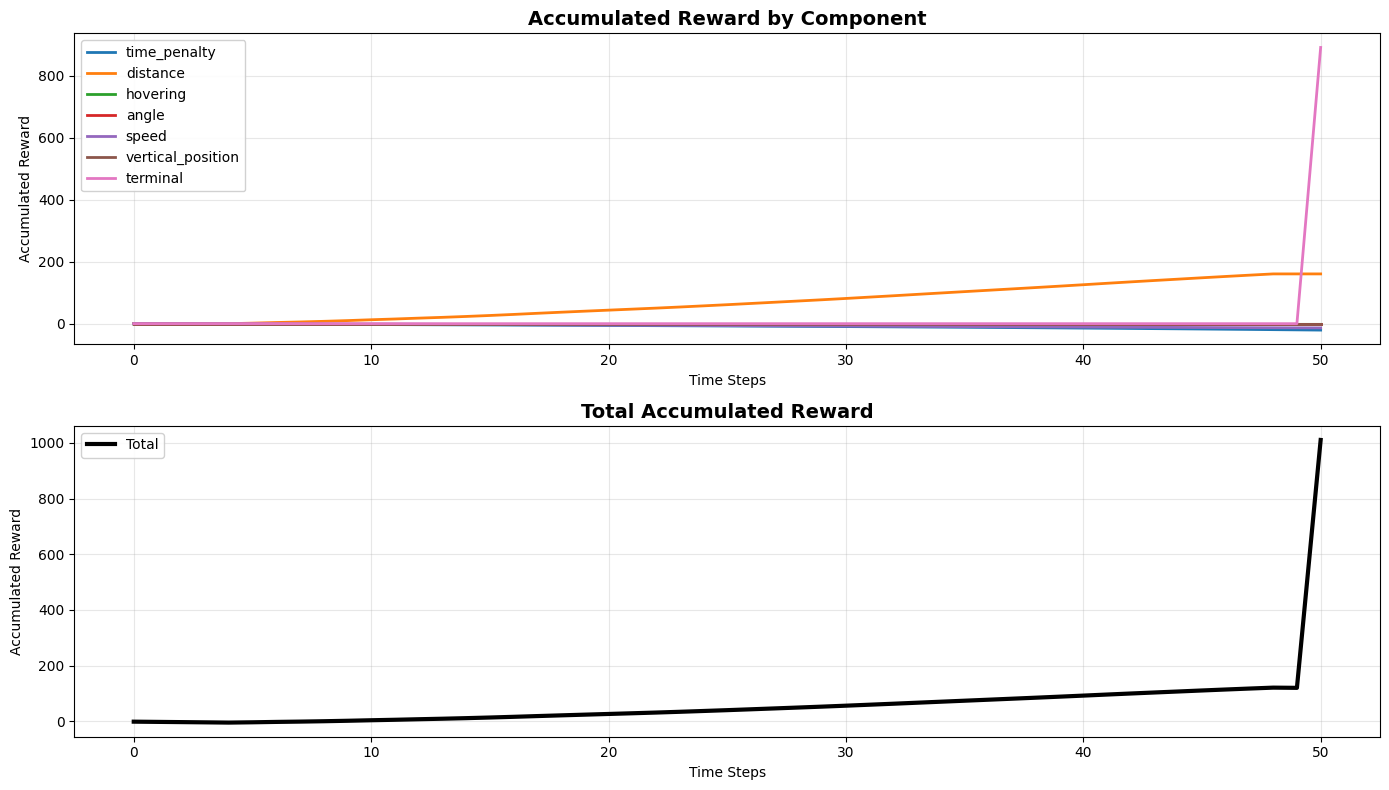

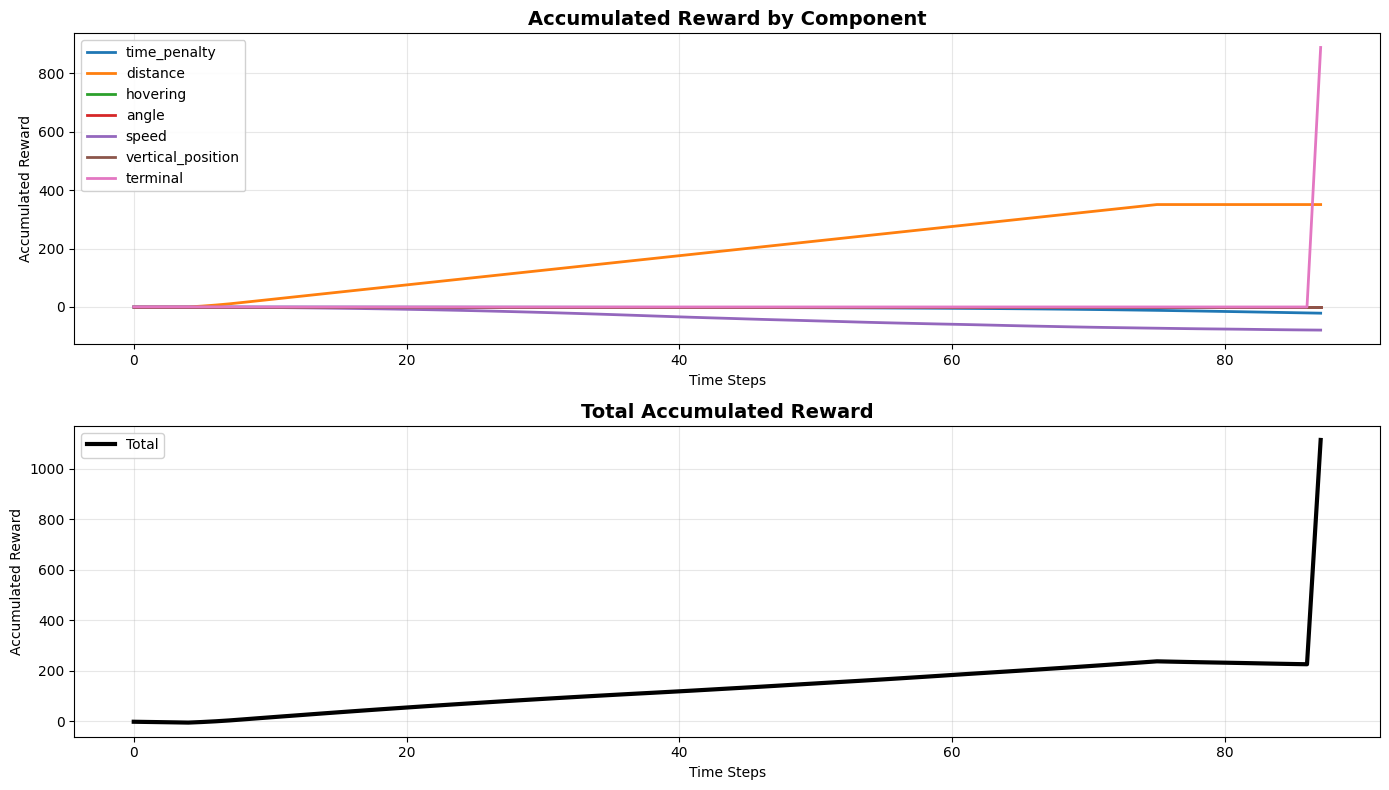

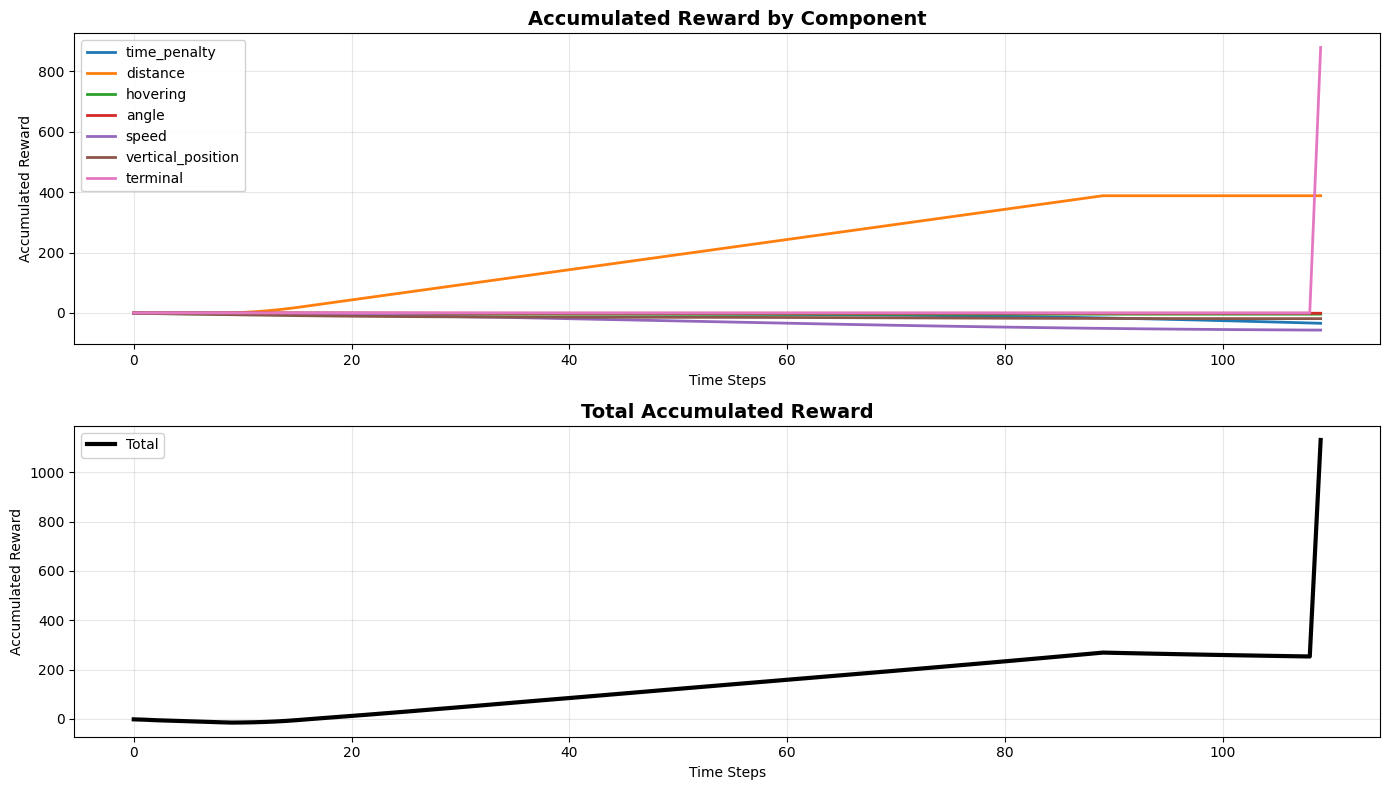

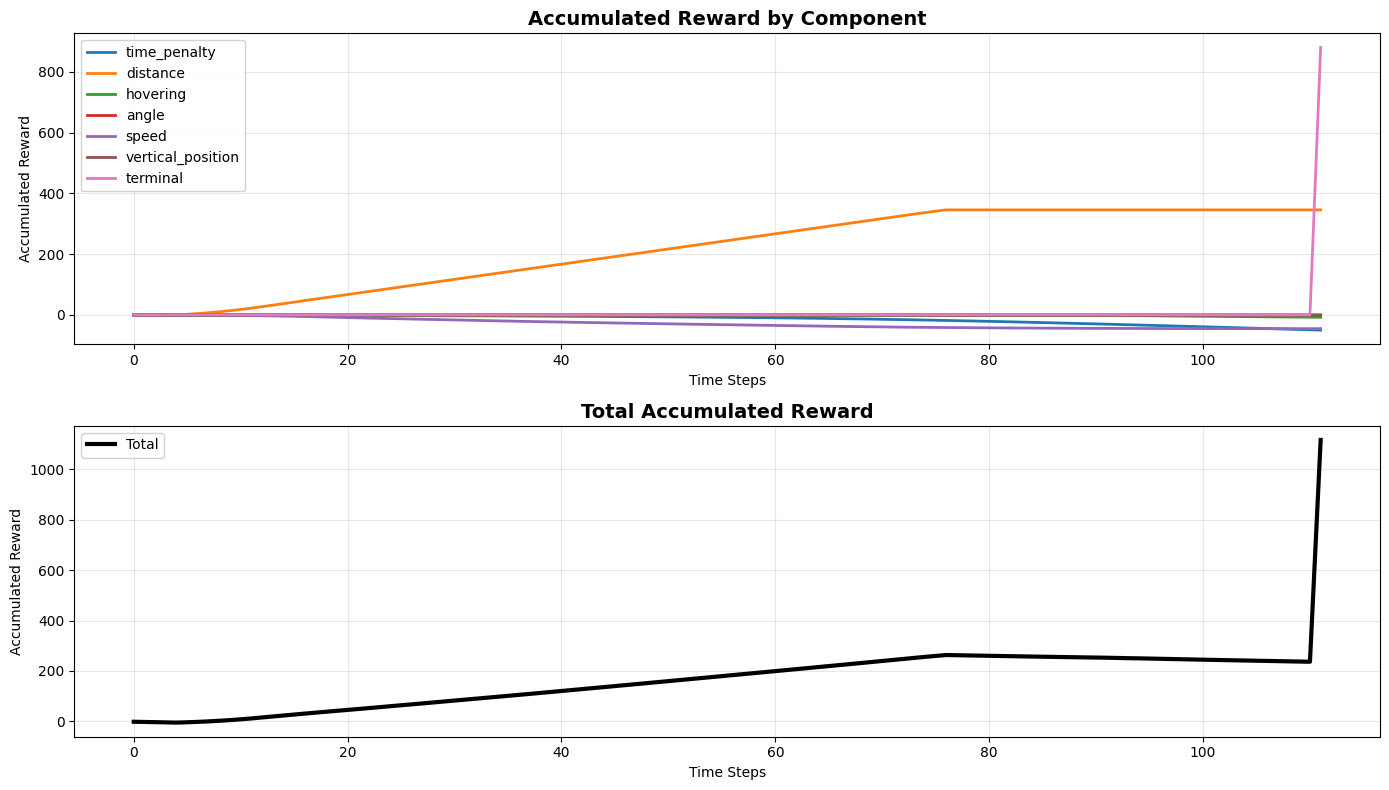

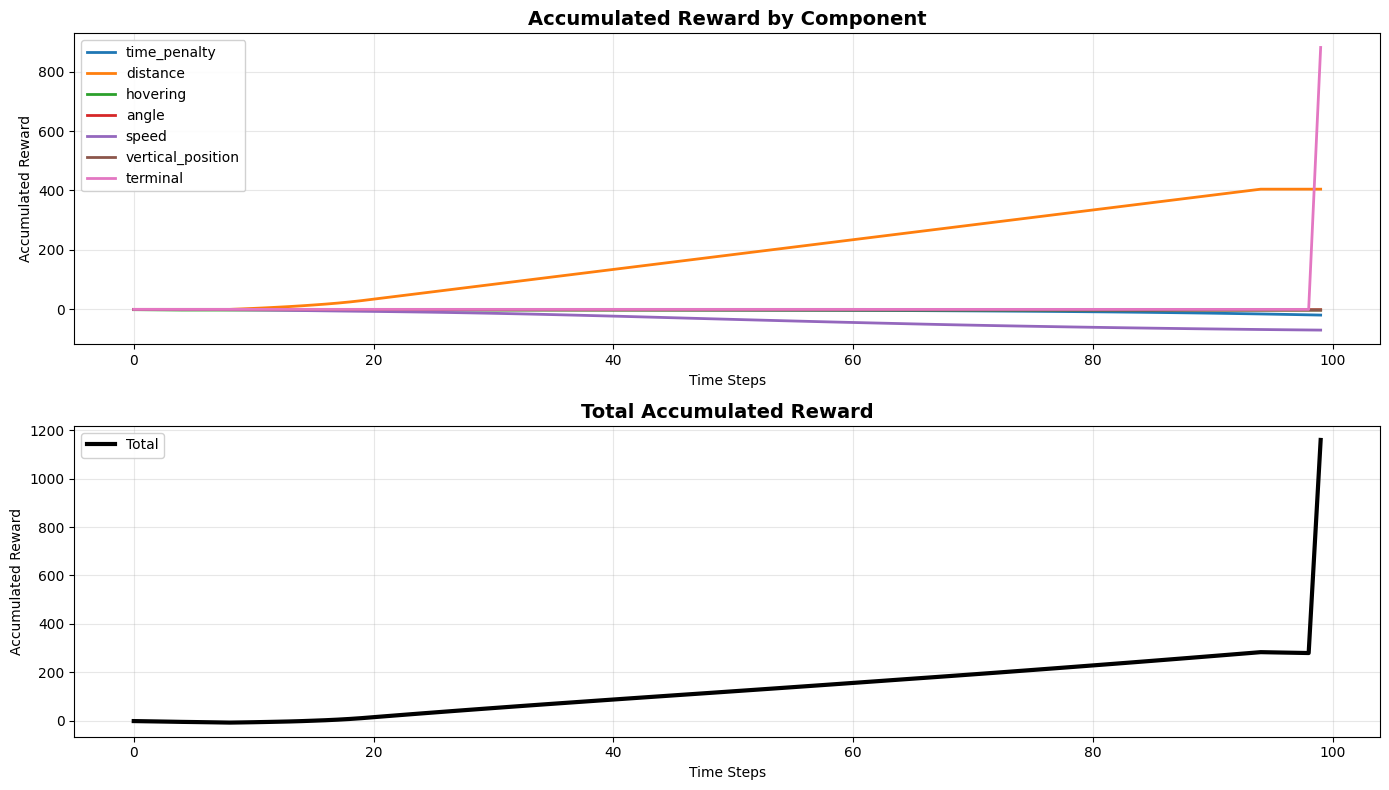

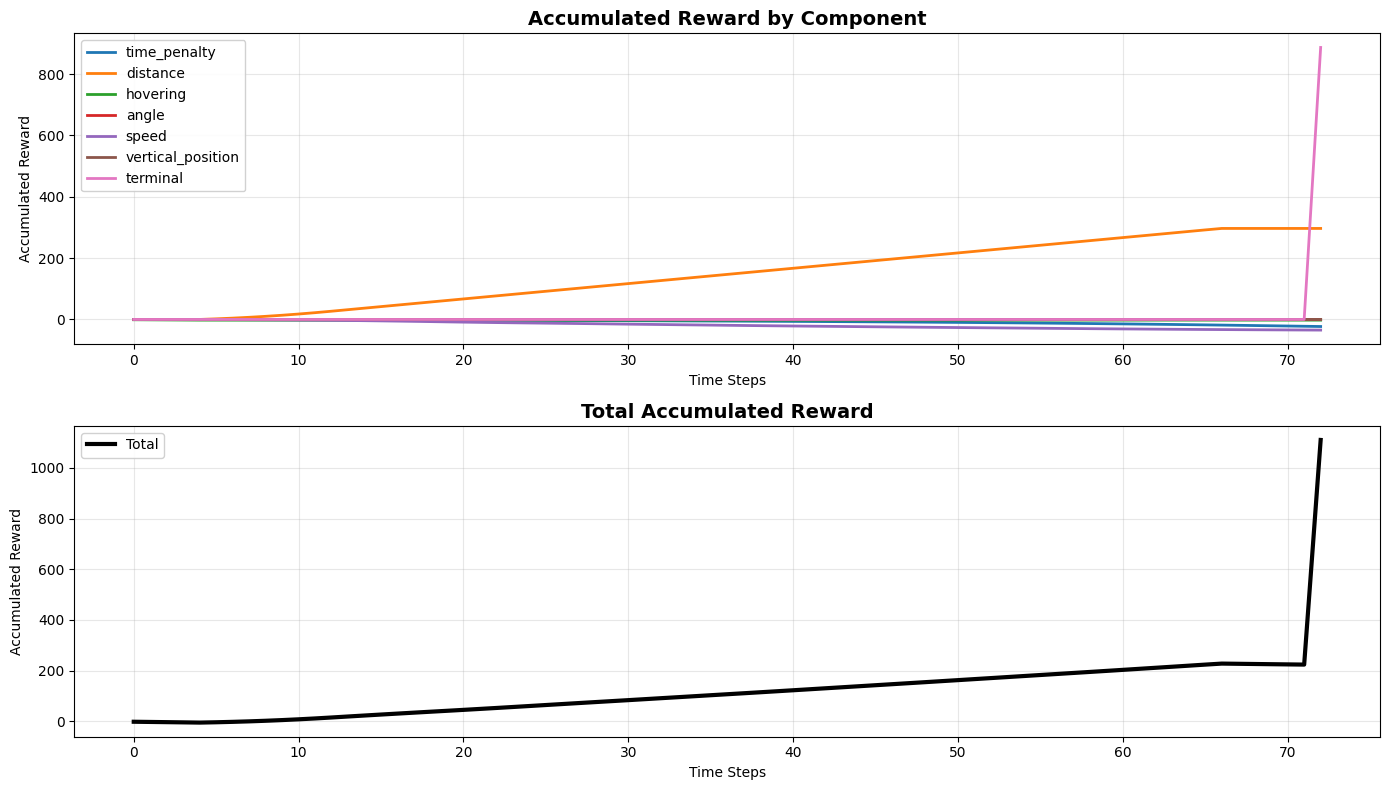

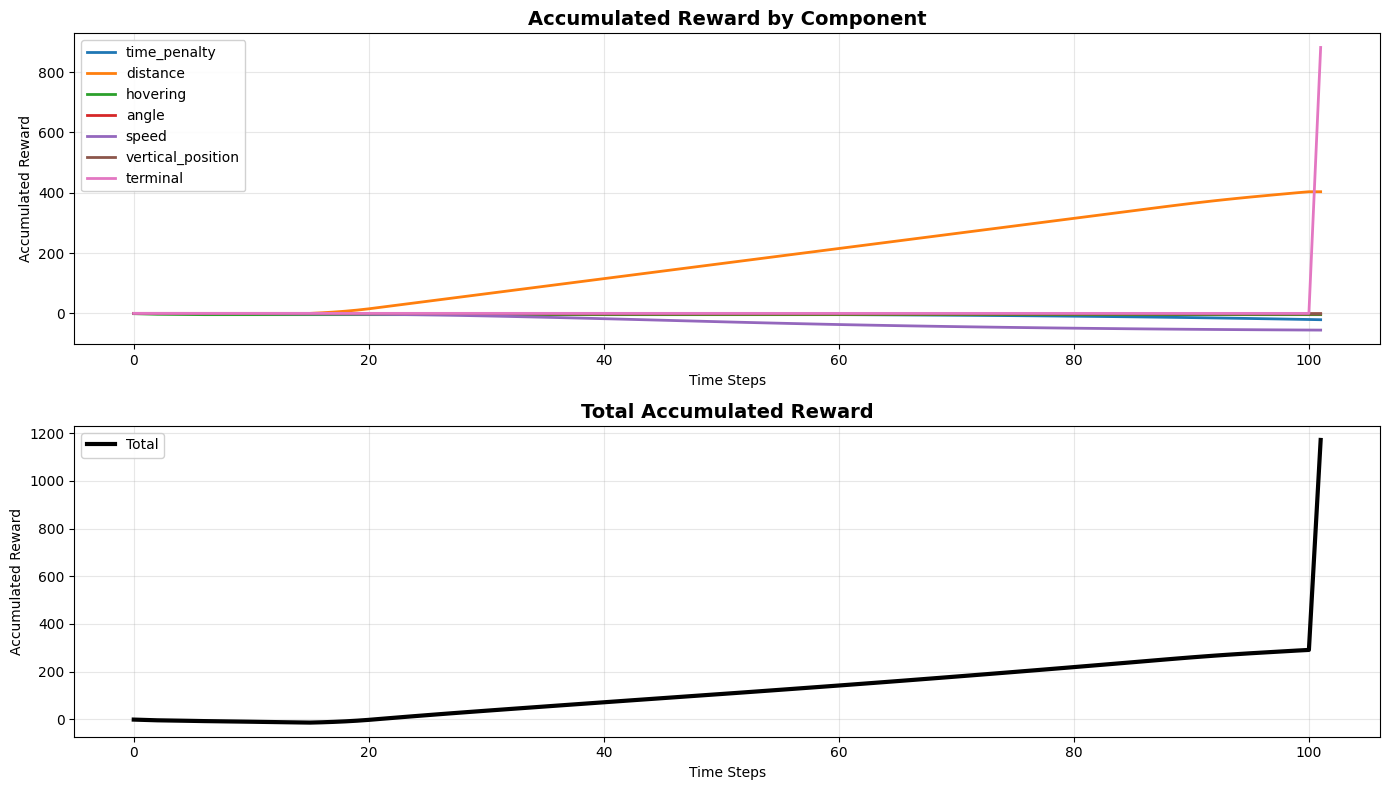

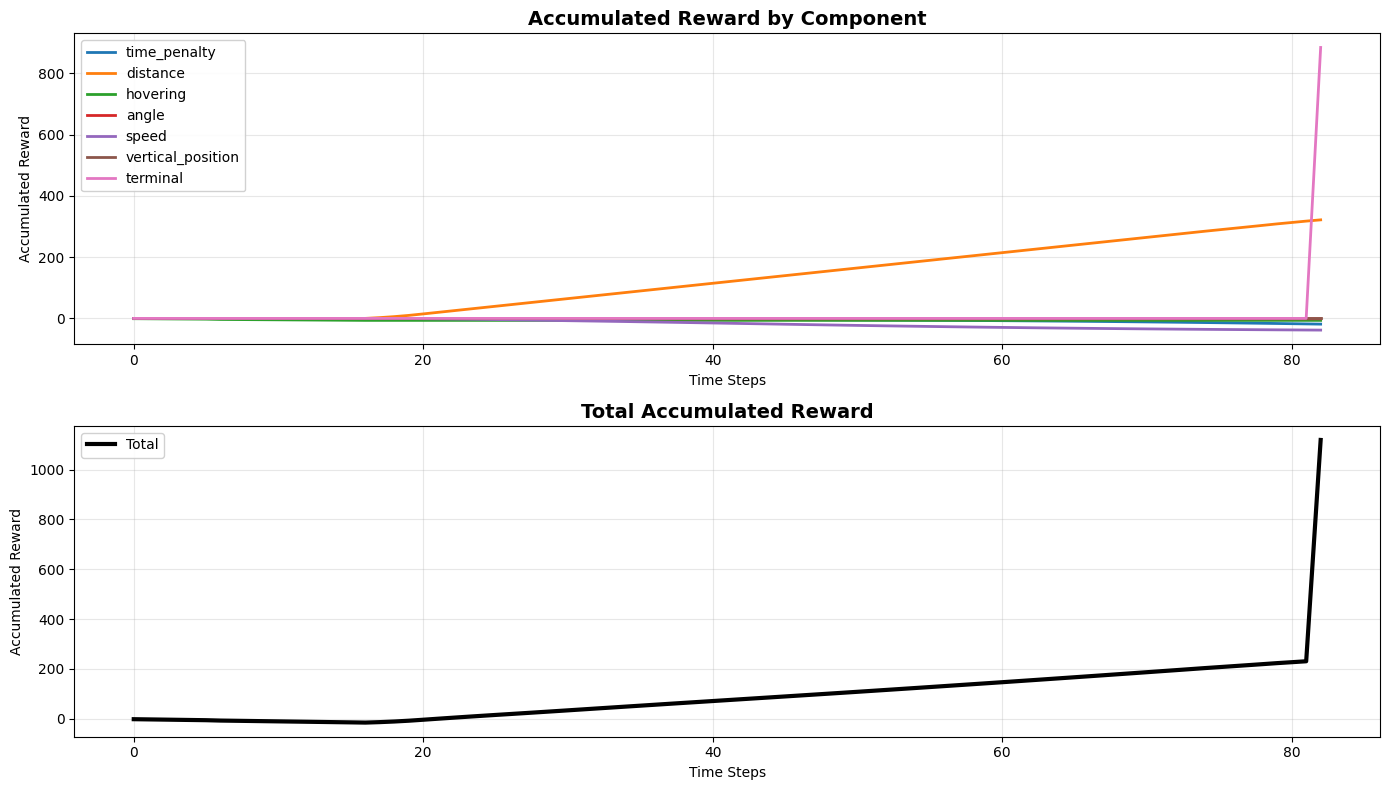

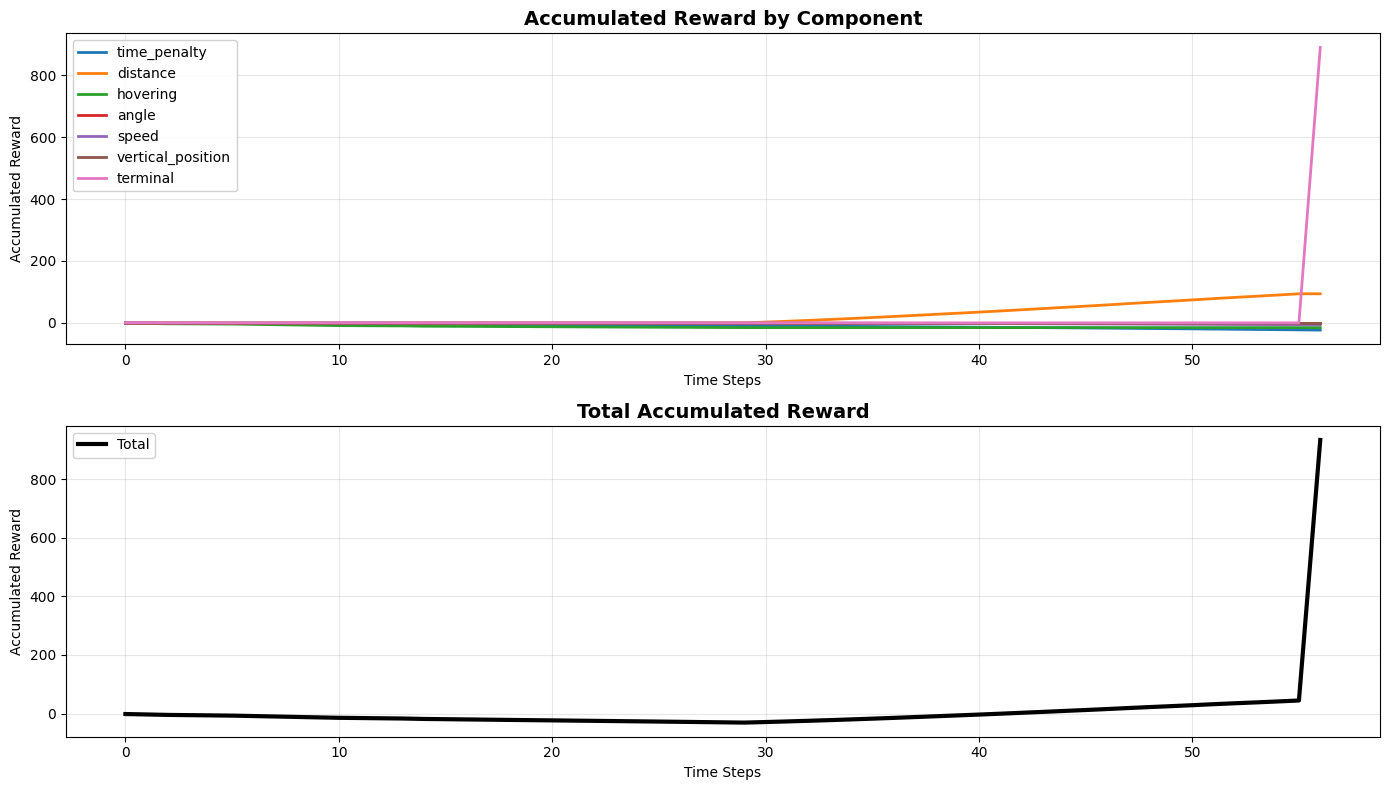

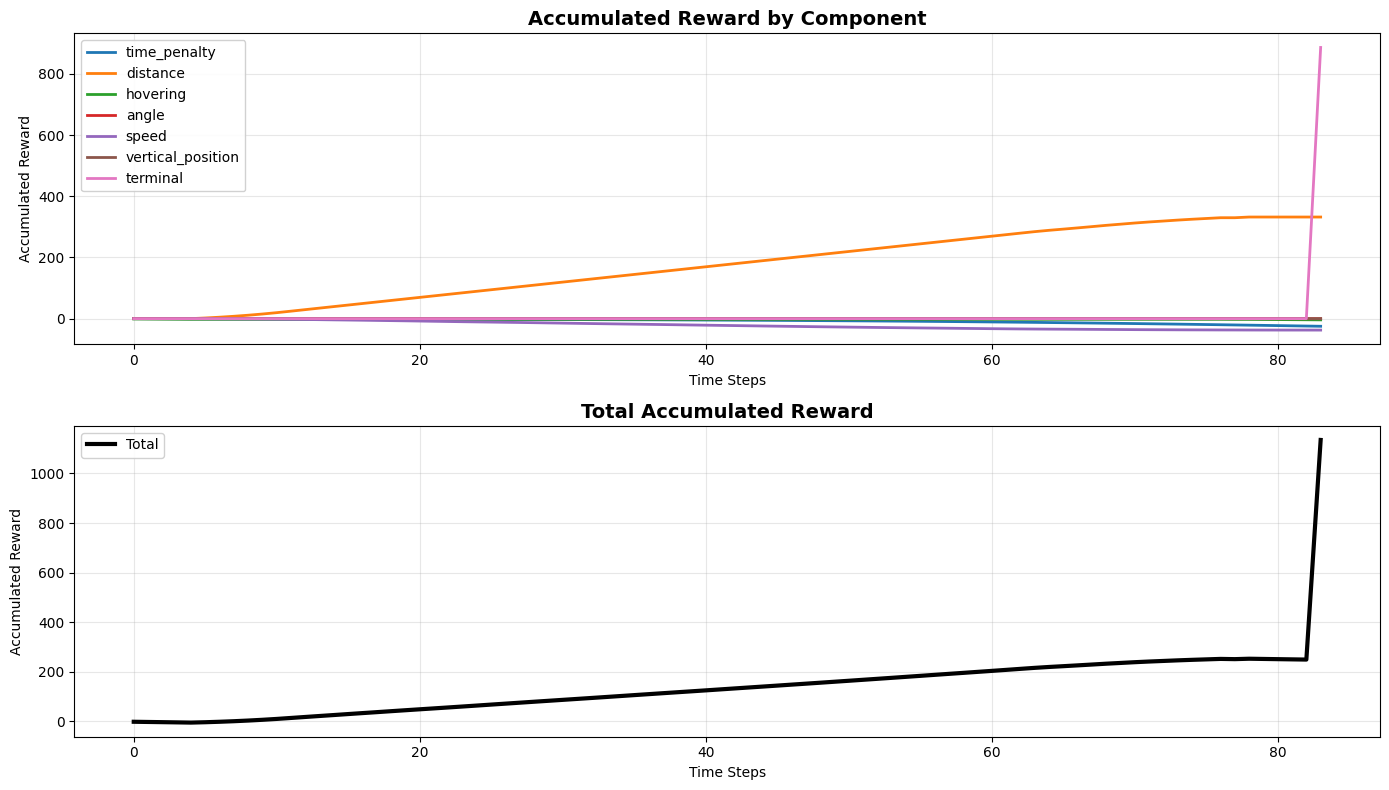

In [22]:
for _ in range(10):
    plot_accumulated_rewards(evaluate_policy(client, policy, max_steps=1000, temperature=1))

In [ ]:
# Load and analyze training metrics
import json
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

# Find the most recent metrics file
metrics_files = glob('./models/actor-critic-ppo/training_metrics_*.json')
if metrics_files:
    latest_metrics = max(metrics_files, key=os.path.getctime)
    print(f"Loading metrics from: {latest_metrics}")
    
    with open(latest_metrics, 'r') as f:
        metrics = json.load(f)
    
    iterations = metrics['iterations']
    
    # Extract data
    iters = [d['iteration'] for d in iterations]
    success_rates = [d['success_rate'] for d in iterations]
    avg_rewards = [d['avg_reward'] for d in iterations]
    policy_losses = [d['policy_loss'] for d in iterations]
    value_losses = [d['value_loss'] for d in iterations]
    ratio_means = [d['ratio_mean'] for d in iterations]
    ratio_mins = [d['ratio_min'] for d in iterations]
    ratio_maxs = [d['ratio_max'] for d in iterations]
    clipped_fracs = [d['clipped_frac'] for d in iterations]
    entropies = [d['entropy'] for d in iterations]
    
    # Create comprehensive plots
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle('PPO Training Metrics', fontsize=16, fontweight='bold')
    
    # Plot 1: Success Rate
    axes[0, 0].plot(iters, success_rates, linewidth=2, color='green')
    axes[0, 0].set_title('Landing Success Rate', fontweight='bold')
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Success Rate')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0, 1])
    
    # Plot 2: Average Reward
    axes[0, 1].plot(iters, avg_rewards, linewidth=2, color='blue')
    axes[0, 1].set_title('Average Episode Reward', fontweight='bold')
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Average Reward')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Policy Loss
    axes[1, 0].plot(iters, policy_losses, linewidth=2, color='red')
    axes[1, 0].set_title('Policy Loss', fontweight='bold')
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Value Loss
    axes[1, 1].plot(iters, value_losses, linewidth=2, color='orange')
    axes[1, 1].set_title('Value Loss', fontweight='bold')
    axes[1, 1].set_xlabel('Iteration')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 5: Ratio Statistics
    axes[2, 0].plot(iters, ratio_means, linewidth=2, label='Mean', color='purple')
    axes[2, 0].fill_between(iters, ratio_mins, ratio_maxs, alpha=0.3, color='purple', label='Min-Max Range')
    axes[2, 0].axhline(y=1.0, color='black', linestyle='--', linewidth=1, label='No Change (1.0)')
    axes[2, 0].axhline(y=1.2, color='red', linestyle=':', linewidth=1, label='Clip Bound (1.2)')
    axes[2, 0].axhline(y=0.8, color='red', linestyle=':', linewidth=1, label='Clip Bound (0.8)')
    axes[2, 0].set_title('Policy Ratio Statistics', fontweight='bold')
    axes[2, 0].set_xlabel('Iteration')
    axes[2, 0].set_ylabel('Ratio (π_new / π_old)')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # Plot 6: Clipped Fraction & Entropy
    ax6 = axes[2, 1]
    ax6_twin = ax6.twinx()
    
    line1 = ax6.plot(iters, clipped_fracs, linewidth=2, color='brown', label='Clipped Fraction')
    ax6.set_xlabel('Iteration')
    ax6.set_ylabel('Clipped Fraction', color='brown')
    ax6.tick_params(axis='y', labelcolor='brown')
    ax6.set_ylim([0, 1])
    
    line2 = ax6_twin.plot(iters, entropies, linewidth=2, color='teal', label='Entropy')
    ax6_twin.set_ylabel('Entropy', color='teal')
    ax6_twin.tick_params(axis='y', labelcolor='teal')
    
    ax6.set_title('Clipping & Exploration', fontweight='bold')
    ax6.grid(True, alpha=0.3)
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax6.legend(lines, labels, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"\nHyperparameters:")
    for key, value in metrics['hyperparameters'].items():
        print(f"  {key}: {value}")
    
    print(f"\n\nFinal Performance (last 100 iterations):")
    last_100 = iterations[-100:]
    print(f"  Success Rate: {np.mean([d['success_rate'] for d in last_100]):.1%}")
    print(f"  Avg Reward: {np.mean([d['avg_reward'] for d in last_100]):.1f}")
    print(f"  Avg Steps: {np.mean([d['avg_steps'] for d in last_100]):.1f}")
    
    print(f"\n\nPPO-Specific Metrics (last 100 iterations):")
    print(f"  Ratio Mean: {np.mean([d['ratio_mean'] for d in last_100]):.3f}")
    print(f"  Clipped Fraction: {np.mean([d['clipped_frac'] for d in last_100]):.1%}")
    print(f"  Entropy: {np.mean([d['entropy'] for d in last_100]):.4f}")
    
    # Find convergence point (when success rate exceeds 50%)
    convergence_iter = next((d['iteration'] for d in iterations if d['success_rate'] >= 0.5), None)
    if convergence_iter:
        print(f"\n\nConvergence Point (50% success): Iteration {convergence_iter}")
    
    print("\n" + "="*60)
else:
    print("No training metrics found. Run training first!")